# Model Development: Titanic-Spaceship <span style="color:orange">**Competition**</span>
<img src="../assets/spaceship-pic.jpg" alt="Title-Pic">

# Imports

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datetime import datetime
from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})

# Data

In [133]:
MODEL_DATA = np.load("../model_data/titanic_spaceship_prep_data.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]
DATA_COLUMN_NAMES = MODEL_DATA["input_column_names"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((7004, 22), (876, 22), (876, 22)), ((7004,), (876,), (876,)))

# Helper Functions

In [134]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [135]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [136]:
def print_top_rankings(model, top=10):
    sorted_zipped_report = sorted(
        zip(
            model.cv_results_["params"], 
            model.cv_results_["mean_test_score"], 
            model.cv_results_["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")
        

In [137]:
def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy-Score:\t{accuracy_score_test}\t|\tTrain-Accuracy-Score:\t{accuracy_score_train}")
    print(f"F1-Score:\t{f1_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')


In [138]:
def print_feature_importance(model):
    return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

# Build the Model

## Model1: GradientBoost XGB Model

### Basic Model

In [139]:
xgb_model = XGBClassifier(nthread=-1)
xgb_model.fit(X_train, y_train);

Accuracy:	0.8002283105022832	|	Train-Accuracy:	0.8779268989149057
F1-Score:	0.8002259674966476	|	Train-F1-Score:	0.8778222324315521

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       441
         1.0       0.79      0.81      0.80       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



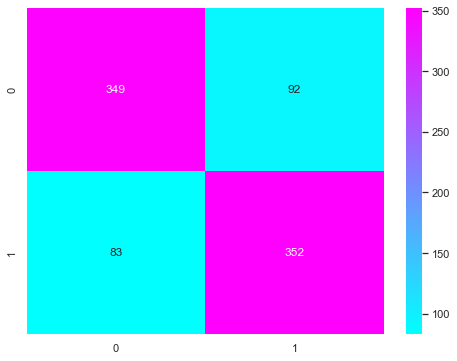

In [140]:
print_model_classification_report(xgb_model, X_test, y_test)

In [141]:
print_feature_importance(xgb_model)

CryoSleep                    0.631288
HomePlanet_Earth             0.127595
HomePlanet_Europa            0.045018
Cabin_E                      0.032505
Spa                          0.016256
VRDeck                       0.015684
RoomService                  0.014957
FoodCourt                    0.013755
HomePlanet_Mars              0.012014
ShoppingMall                 0.011804
Cabin_C                      0.009650
Destination_PSO J318.5-22    0.009591
Age                          0.009481
Destination_TRAPPIST-1e      0.009092
Cabin_B                      0.008898
Cabin_F                      0.007897
Destination_55 Cancri e      0.006312
Cabin_D                      0.006199
Cabin_G                      0.005731
Cabin_A                      0.003745
VIP                          0.002529
Cabin_T                      0.000000
dtype: float32

In [142]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'nthread': -1}

### GridModel

In [143]:
xgb_tmp_model = XGBClassifier(nthread=-1,)

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "learning_rate": [0.05],
    "min_child_weight": [3],
    "n_estimators": np.arange(95, 200, 1),
    "eta": [0.05],
    "gamma": [1],
    "subsample": [0.6],
    "max_depth": [3],
    "colsample_bytree": [0.5]
}

In [144]:
xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=2, scoring="accuracy", verbose=3)

xgb_grid_model.fit(X_train, y_train);

Fitting 2 folds for each of 105 candidates, totalling 210 fits
[CV 1/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=95, subsample=0.6;, score=0.788 total time=   0.1s
[CV 2/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=95, subsample=0.6;, score=0.778 total time=   0.1s
[CV 1/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=96, subsample=0.6;, score=0.788 total time=   0.1s
[CV 2/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=96, subsample=0.6;, score=0.779 total time=   0.1s
[CV 1/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=97, subsample=0.6;, score=0.

Accuracy:	0.8047945205479452	|	Train-Accuracy:	0.799114791547687
F1-Score:	0.8046354031491318	|	Train-F1-Score:	0.7987529235279007

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       441
         1.0       0.78      0.84      0.81       435

    accuracy                           0.80       876
   macro avg       0.81      0.81      0.80       876
weighted avg       0.81      0.80      0.80       876



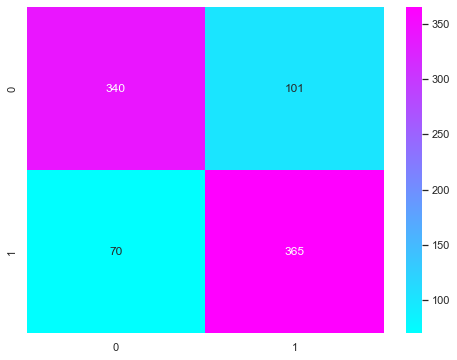

In [145]:
print_model_classification_report(xgb_grid_model, X_test, y_test)

In [146]:
print_top_rankings(xgb_grid_model, 50)

Rank: 1	Score: 0.7894060536836094
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 159, 'subsample': 0.6}

Rank: 2	Score: 0.7892632781267848
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 195, 'subsample': 0.6}

Rank: 2	Score: 0.7892632781267848
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 196, 'subsample': 0.6}

Rank: 4	Score: 0.78912050256996
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 152, 'subsample': 0.6}

Rank: 4	Score: 0.78912050256996
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learn

### Best Model Selection

In [147]:
xgb_best_model = xgb_grid_model.best_estimator_

## Model2: KNearestNeighbor KNN

### Basic Model

Accuracy:	0.7796803652968036	|	Train-Accuracy:	0.7789834380354084
F1-Score:	0.7794386427234242	|	Train-F1-Score:	0.7787769163247993

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       441
         1.0       0.79      0.75      0.77       435

    accuracy                           0.78       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.78      0.78      0.78       876



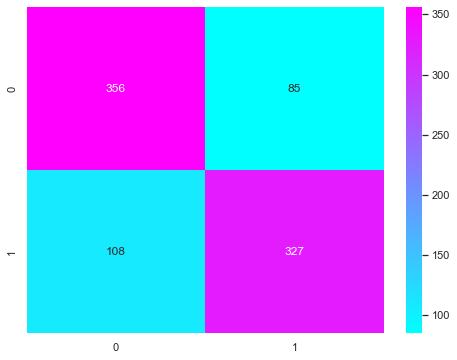

In [148]:
knn_model = KNeighborsClassifier(21) #21 -> 80,249
knn_model.fit(X_train, y_train)
print_model_classification_report(knn_model, X_test, y_test)

### GridModel

In [149]:
knn_tmp_model = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": np.arange(3, 50, 1),
    "metric": ["manhattan"],
    "weights": ["distance"]
}

In [150]:
knn_grid_model = GridSearchCV(knn_tmp_model, knn_grid_params, cv=3, scoring="accuracy", verbose=3)

knn_grid_model.fit(X_train, y_train);

Fitting 3 folds for each of 47 candidates, totalling 141 fits
[CV 1/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.739 total time=   0.1s
[CV 2/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.733 total time=   0.1s
[CV 3/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.731 total time=   0.0s
[CV 1/3] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.735 total time=   0.0s
[CV 2/3] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.709 total time=   0.0s
[CV 3/3] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.718 total time=   0.0s
[CV 1/3] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.750 total time=   0.0s
[CV 2/3] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.742 total time=   0.0s
[CV 3/3] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.731 total time=   0.0s
[CV 1/3] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.7

Accuracy:	0.7682648401826484	|	Train-Accuracy:	0.9087664191890349
F1-Score:	0.7672795229065326	|	Train-F1-Score:	0.9087565073247599

              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       441
         1.0       0.80      0.71      0.75       435

    accuracy                           0.77       876
   macro avg       0.77      0.77      0.77       876
weighted avg       0.77      0.77      0.77       876



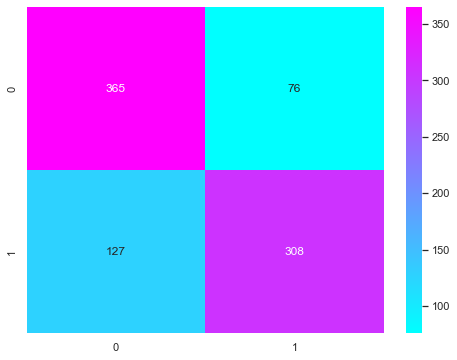

In [151]:
print_model_classification_report(knn_grid_model, X_test, y_test)

In [152]:
print_top_rankings(knn_grid_model, 20)

Rank: 1	Score: 0.764419893490205
Param: {'metric': 'manhattan', 'n_neighbors': 35, 'weights': 'distance'}

Rank: 2	Score: 0.7642771994786438
Param: {'metric': 'manhattan', 'n_neighbors': 33, 'weights': 'distance'}

Rank: 3	Score: 0.7637063011057715
Param: {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'distance'}

Rank: 4	Score: 0.7634204849394514
Param: {'metric': 'manhattan', 'n_neighbors': 46, 'weights': 'distance'}

Rank: 5	Score: 0.7629922194148261
Param: {'metric': 'manhattan', 'n_neighbors': 36, 'weights': 'distance'}

Rank: 5	Score: 0.7629922194148261
Param: {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}

Rank: 7	Score: 0.762849341913323
Param: {'metric': 'manhattan', 'n_neighbors': 41, 'weights': 'distance'}

Rank: 8	Score: 0.762706647901762
Param: {'metric': 'manhattan', 'n_neighbors': 42, 'weights': 'distance'}

Rank: 9	Score: 0.762706586738448
Param: {'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance'}

Rank: 10	Score: 0.76270646441181

### Best Model Selection

In [153]:
knn_best_model = knn_model

## Model3: RandomForest

### Basic Model

Accuracy:	0.8082191780821918	|	Train-Accuracy:	0.9164762992575671
F1-Score:	0.808218178406301	|	Train-F1-Score:	0.9162412896994228

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       441
         1.0       0.80      0.82      0.81       435

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876



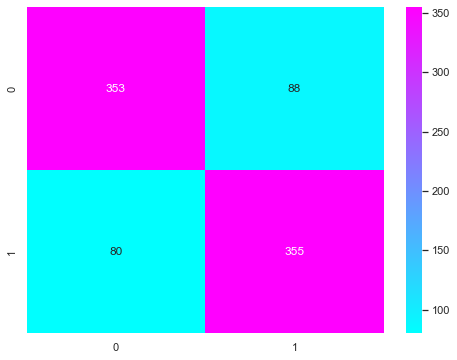

In [154]:
rf_model = RandomForestClassifier(n_estimators=320, random_state=101) # 320 -> 81.24
rf_model.fit(X_train, y_train)
print_model_classification_report(rf_model, X_test, y_test)

### GridModel

In [155]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": np.arange(7, 15, 1),
    "min_samples_split": [2, 3],
    "min_samples_leaf": [2, 3],

    # BaggingClassifier params
    "n_estimators": np.arange(90, 120, 2),
    "max_samples": [0.8],
    "bootstrap": [True]
}

In [156]:
rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=2, scoring="accuracy", verbose=3)

rf_grid_model.fit(X_train, y_train);

Fitting 2 folds for each of 480 candidates, totalling 960 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=90;, score=0.782 total time=   0.1s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=90;, score=0.774 total time=   0.1s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=92;, score=0.787 total time=   0.1s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=92;, score=0.775 total time=   0.1s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=94;, score=0.788 total time=   0.1s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split

Accuracy:	0.8082191780821918	|	Train-Accuracy:	0.8440890919474586
F1-Score:	0.808170181704424	|	Train-F1-Score:	0.8439488062454037

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81       441
         1.0       0.79      0.83      0.81       435

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876



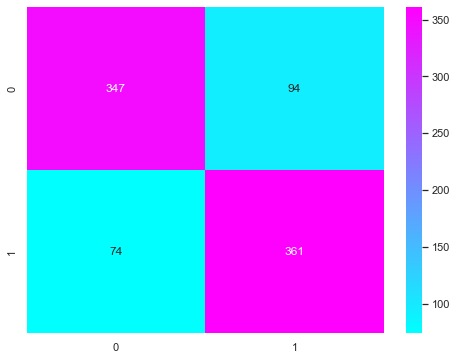

In [157]:
print_model_classification_report(rf_grid_model, X_test, y_test)

In [158]:
print_top_rankings(rf_grid_model, 20)

Rank: 1	Score: 0.7892632781267847
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Rank: 2	Score: 0.78912050256996
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_samples': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 94}

Rank: 2	Score: 0.78912050256996
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 13, 'max_samples': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 96}

Rank: 2	Score: 0.78912050256996
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 14, 'max_samples': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 106}

Rank: 5	Score: 0.7889777270131353
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 14, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 118}

Rank: 6	Score: 0.788692175899486
Param: {'bootstrap': True, 'criteri

### Best Model Selection

In [159]:
rf_best_model = rf_grid_model.best_estimator_

## Model4 - Support Vector Machine SVM

### Basic Model

Accuracy:	0.7831050228310502	|	Train-Accuracy:	0.7948315248429468
F1-Score:	0.7830767546489138	|	Train-F1-Score:	0.7947998638978315

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       441
         1.0       0.77      0.80      0.79       435

    accuracy                           0.78       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.78      0.78      0.78       876



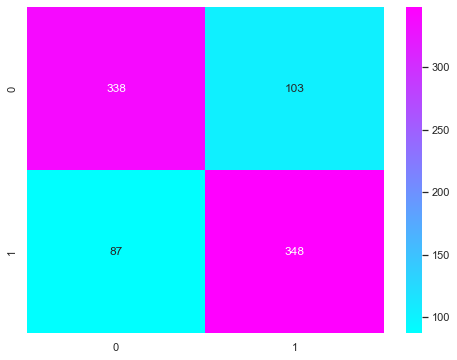

In [160]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
print_model_classification_report(svm_model, X_test, y_test)

### GridModel

In [161]:
svm_tmp_model = SVC(probability=True)

svm_grid_params = {
    "C": [5],
    "gamma": ["auto"],
    "kernel": ["poly"],
    "degree": [1, 2, 3],
    "coef0": [1]
}

In [162]:
svm_grid_model = GridSearchCV(svm_tmp_model, svm_grid_params, cv=2, scoring="accuracy", verbose=3)

svm_grid_model.fit(X_train, y_train);

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END C=5, coef0=1, degree=1, gamma=auto, kernel=poly;, score=0.773 total time=   0.9s
[CV 2/2] END C=5, coef0=1, degree=1, gamma=auto, kernel=poly;, score=0.762 total time=   0.9s
[CV 1/2] END C=5, coef0=1, degree=2, gamma=auto, kernel=poly;, score=0.786 total time=   1.0s
[CV 2/2] END C=5, coef0=1, degree=2, gamma=auto, kernel=poly;, score=0.776 total time=   1.1s
[CV 1/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=poly;, score=0.781 total time=   1.2s
[CV 2/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=poly;, score=0.775 total time=   1.2s


Accuracy:	0.7853881278538812	|	Train-Accuracy:	0.7948315248429468
F1-Score:	0.7852269170579029	|	Train-F1-Score:	0.7944669107027345

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       441
         1.0       0.77      0.82      0.79       435

    accuracy                           0.79       876
   macro avg       0.79      0.79      0.79       876
weighted avg       0.79      0.79      0.79       876



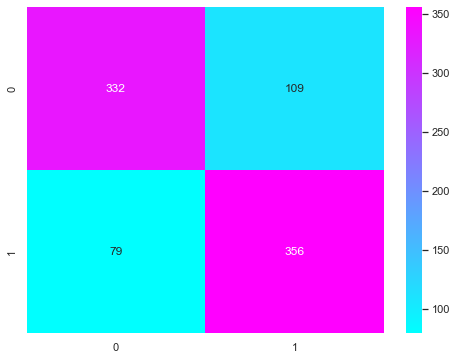

In [163]:
print_model_classification_report(svm_grid_model, X_test, y_test)

In [164]:
print_top_rankings(svm_grid_model, 20)

Rank: 1	Score: 0.7808395202741291
Param: {'C': 5, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}

Rank: 2	Score: 0.7778412335808109
Param: {'C': 5, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

Rank: 3	Score: 0.7674186179326099
Param: {'C': 5, 'coef0': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}



### Best Model Selection

In [165]:
svm_best_model = svm_grid_model.best_estimator_

## Model5 - DecisionTree

### Basic Model

Accuracy:	0.7545662100456622	|	Train-Accuracy:	0.9164762992575671
F1-Score:	0.7535948798392362	|	Train-F1-Score:	0.9162731521437433

              precision    recall  f1-score   support

         0.0       0.80      0.69      0.74       441
         1.0       0.72      0.82      0.77       435

    accuracy                           0.75       876
   macro avg       0.76      0.76      0.75       876
weighted avg       0.76      0.75      0.75       876



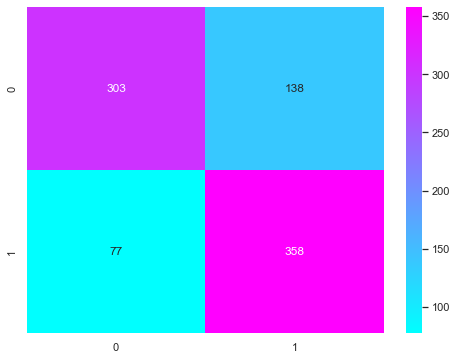

In [166]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
print_model_classification_report(dt_model, X_test, y_test)

In [167]:
dt_best_model = dt_model

## Model6 - EnsembleModel1 -> VotingClassifier

In [168]:
estimators_c1 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
    ("xgb", xgb_best_model),
    ("svm", svm_best_model),
    ("dt", dt_best_model)
]

estimators_c2 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
    ("xgb", xgb_best_model),
    ("svm", svm_best_model)
]

estimators_c3 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
    ("svm", svm_best_model)
]

estimators_c4 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
    ("xgb", xgb_best_model)
]

estimators_c5 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model)
]

In [169]:
vc_model1 = VotingClassifier(estimators=estimators_c1, voting="soft")
vc_model2 = VotingClassifier(estimators=estimators_c2, voting="soft")
vc_model3 = VotingClassifier(estimators=estimators_c3, voting="soft")
vc_model4 = VotingClassifier(estimators=estimators_c4, voting="soft")
vc_model5 = VotingClassifier(estimators=estimators_c5, voting="soft")

vc_model1.fit(X_train, y_train)
vc_model2.fit(X_train, y_train)
vc_model3.fit(X_train, y_train)
vc_model4.fit(X_train, y_train)
vc_model5.fit(X_train, y_train);

Accuracy:	0.8070776255707762	|	Train-Accuracy:	0.8600799543118218
F1-Score:	0.8069203691941713	|	Train-F1-Score:	0.8599540568869006

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       441
         1.0       0.79      0.84      0.81       435

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876

Accuracy:	0.795662100456621	|	Train-Accuracy:	0.8112507138777841
F1-Score:	0.795585116160227	|	Train-F1-Score:	0.8111259683496215

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       441
         1.0       0.78      0.82      0.80       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876

Accuracy:	0.7888127853881278	|	Train-Accuracy:	0.8111079383209594
F1-Score:	0.7887

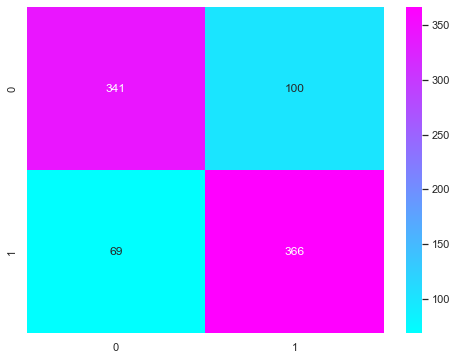

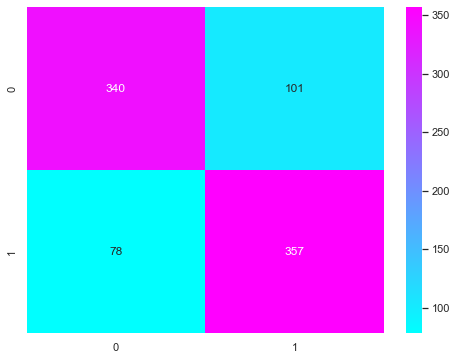

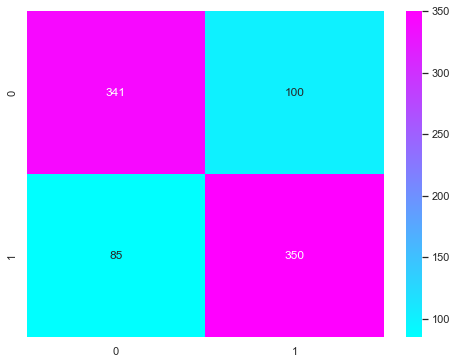

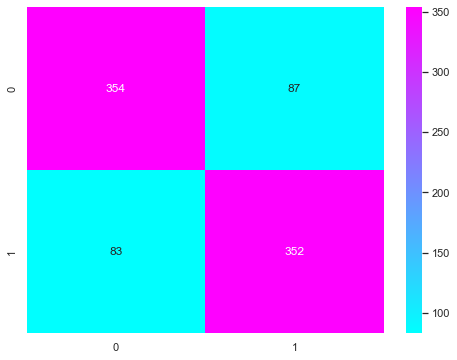

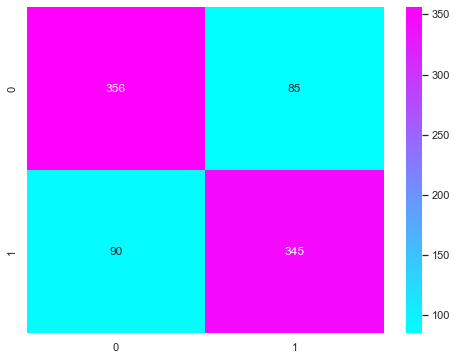

In [170]:
print_model_classification_report(vc_model1, X_test, y_test)
print_model_classification_report(vc_model2, X_test, y_test)
print_model_classification_report(vc_model3, X_test, y_test)
print_model_classification_report(vc_model4, X_test, y_test) # this
print_model_classification_report(vc_model5, X_test, y_test)

In [171]:
grid_estimators_c1 = [
    ("svm", svm_best_model),
    ("rf", rf_best_model),
    ("xgb", xgb_best_model),
    ("knn", knn_best_model),
]

grid_estimators_c2 = [
    ("rf", rf_best_model),
    ("svm", svm_best_model),
    ("knn", knn_best_model),
]

grid_estimators_c3 = [
    ("svm", svm_best_model),
    ("rf", rf_best_model),
    ("xgb", xgb_best_model),
]

In [172]:
vc_grid_model1 = VotingClassifier(estimators=grid_estimators_c1, voting="soft")
vc_grid_model2 = VotingClassifier(estimators=grid_estimators_c2, voting="soft")
vc_grid_model3 = VotingClassifier(estimators=grid_estimators_c3, voting="soft")

vc_grid_model1.fit(X_train, y_train)
vc_grid_model2.fit(X_train, y_train)
vc_grid_model3.fit(X_train, y_train);

Accuracy:	0.8184931506849316	|	Train-Accuracy:	0.8118218161050829
F1-Score:	0.8184815600128759	|	Train-F1-Score:	0.8116861392679398

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       444
         1.0       0.80      0.84      0.82       432

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876

Accuracy:	0.8093607305936074	|	Train-Accuracy:	0.8112507138777841
F1-Score:	0.8093604821632188	|	Train-F1-Score:	0.8111203586296483

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       444
         1.0       0.80      0.82      0.81       432

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876

Accuracy:	0.817351598173516	|	Train-Accuracy:	0.8145345516847515
F1-Score:	0.817

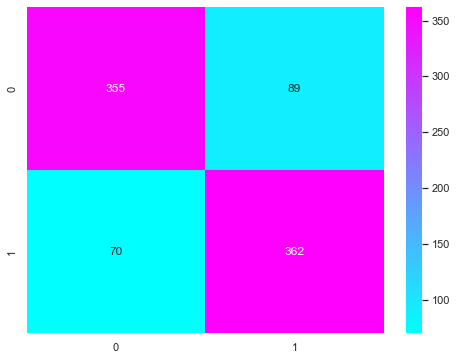

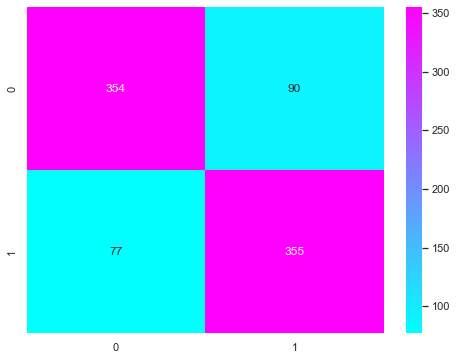

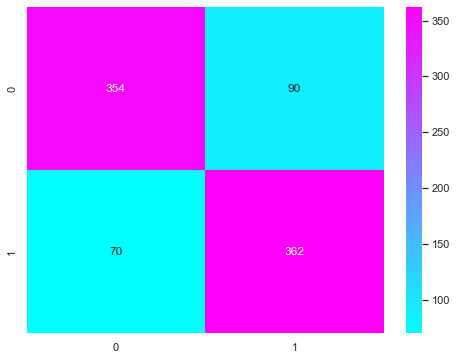

In [173]:
print_model_classification_report(vc_grid_model1, X_val, y_val) # this
print_model_classification_report(vc_grid_model2, X_val, y_val) # this
print_model_classification_report(vc_grid_model3, X_val, y_val) # this

Accuracy:	0.8162100456621004	|	Train-Accuracy:	0.799114791547687
F1-Score:	0.8161043634727845	|	Train-F1-Score:	0.7987529235279007

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       444
         1.0       0.79      0.85      0.82       432

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876

Accuracy:	0.819634703196347	|	Train-Accuracy:	0.7948315248429468
F1-Score:	0.8195745124621963	|	Train-F1-Score:	0.7944669107027345

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       444
         1.0       0.80      0.85      0.82       432

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876

Accuracy:	0.8184931506849316	|	Train-Accuracy:	0.8440890919474586
F1-Score:	0.8184

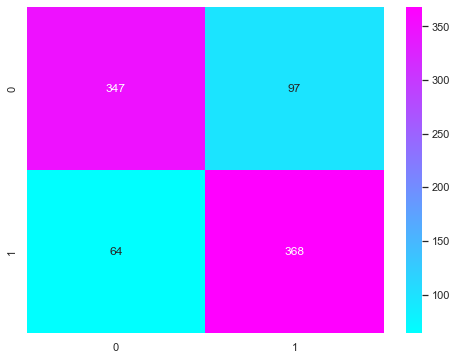

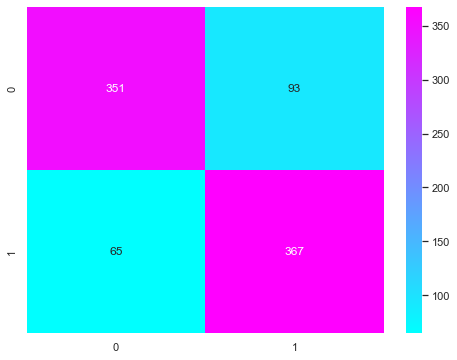

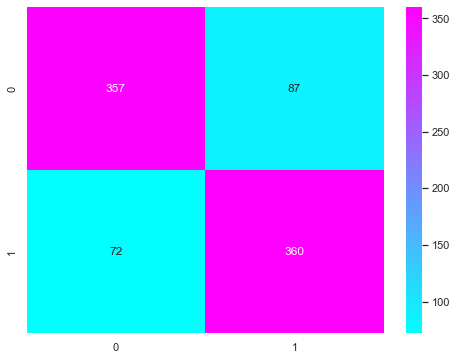

In [174]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_val, y_val) # this
print_model_classification_report(svm_grid_model.best_estimator_, X_val, y_val) # this
print_model_classification_report(rf_grid_model.best_estimator_, X_val, y_val)  # this

# Final Model Selection

In [176]:
final_models = [
    ("VC_M4", vc_model4),
    ("VC_GM1", vc_grid_model1),
    ("VC_GM2", vc_grid_model2),
    ("VC_GM3", vc_grid_model3),
    ("XGB_M", xgb_grid_model.best_estimator_),
    ("SVM_M", svm_grid_model.best_estimator_),
    ("RF_M", rf_grid_model.best_estimator_)     # Best-Score: 0.80126
]

# Create Submissions

In [178]:
TEST_DATA_PATH = "../model_data/submission_test_data.csv"

In [179]:
def get_submission_csv_df(model, test_data_path):
    df_test_data = pd.read_csv(test_data_path)
    preds = Series(model.predict(df_test_data.drop(columns=["PassengerId"]).to_numpy())).map({0: False, 1: True})
    return DataFrame({"PassengerId": df_test_data["PassengerId"].to_numpy(), "Transported": preds})

def save_submissions(df, csv_name):
    df.to_csv(f"../submissions/{csv_name}.csv", index=False)

In [181]:
for model_name, model in final_models:
    submission_df = get_submission_csv_df(model, TEST_DATA_PATH)
    submission_csv_name = f"2022-08-06_Submission_{model_name}"
    save_submissions(submission_df, submission_csv_name)
    print(f"Saved: {submission_csv_name}")

Saved: 2022-08-06_Submission_VC_M4
Saved: 2022-08-06_Submission_VC_GM1
Saved: 2022-08-06_Submission_VC_GM2
Saved: 2022-08-06_Submission_VC_GM3
Saved: 2022-08-06_Submission_XGB_M
Saved: 2022-08-06_Submission_SVM_M
Saved: 2022-08-06_Submission_RF_M
